# Exploring the UTx000 Extension EMA Data
(See the [GH repo](https://github.com/intelligent-environments-lab/utx000))

# EMA Summary
In this notebook we look at the various EMA data with a focus on the sleep data from the morning EMAs.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Package Import

In [2]:
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from datetime import datetime, timedelta
import math

## Data Import

### Morning Survey Data

In [3]:
sleep_survey = pd.read_csv('../data/processed/beiwe-morning_ema-ux_s20.csv',
                           index_col=0,parse_dates=True,infer_datetime_format=True)
sleep_survey.head()

,beiwe,content,stress,lonely,sad,energy,tst,sol,naw,restful
timestamp,,,,,,,,,,
2020-05-13 09:10:27,qh34m4r9,3.0,0.0,0.0,0.0,1.0,8.0,20.0,2.0,3.0
2020-05-13 09:15:49,awa8uces,0.0,2.0,1.0,1.0,1.0,2.0,10.0,3.0,1.0
2020-05-13 09:42:19,xxvnhauv,1.0,1.0,1.0,3.0,0.0,6.0,30.0,3.0,1.0
2020-05-13 09:43:27,rvhdl2la,1.0,1.0,2.0,3.0,0.0,5.3,5.0,2.0,2.0
2020-05-13 10:11:51,q5y11ytm,3.0,1.0,0.0,1.0,2.0,2.0,10.0,0.0,0.0


### Evening Survey Data

In [4]:
evening_survey = pd.read_csv('../data/processed/beiwe-evening_ema-ux_s20.csv',
                             index_col=0,parse_dates=True,infer_datetime_format=True)
evening_survey.head()

,beiwe,content,stress,lonely,sad,energy
timestamp,,,,,,
2020-05-13 19:00:23,awa8uces,1.0,1,1.0,3,2
2020-05-13 19:21:32,lkkjddam,0.0,2,3.0,1,0
2020-05-13 19:30:38,rvhdl2la,2.0,1,0.0,0,1
2020-05-13 20:07:04,xxvnhauv,1.0,3,1.0,2,0
2020-05-13 20:25:07,xdbdrk6e,2.0,1,2.0,1,3


### Weekly Survey Data

In [5]:
weekly_survey = pd.read_csv('../data/processed/beiwe-weekly_ema-ux_s20.csv',index_col=0,parse_dates=True)
weekly_survey.head()

,beiwe,upset,unable,stressed,confident,your_way,cope,able,top,angered,overcome
timestamp,,,,,,,,,,,
2020-05-14 11:29:37,hcpu5myv,2,2.0,2,2,2.0,1,2,1,1,1
2020-05-16 06:28:30,shi1ykro,2,0.0,3,3,2.0,0,4,1,0,0
2020-05-16 06:40:30,9xmhtq74,0,0.0,2,4,4.0,0,3,3,0,0
2020-05-16 07:38:51,awa8uces,3,3.0,4,2,2.0,3,2,1,1,4
2020-05-16 07:46:55,rvhdl2la,2,2.0,3,2,2.0,3,1,2,3,2


# Survey Data Overview
Here we get a sense of the data we are using for the EMAs

## Available Data
We can take a look at how many submission for a particular questions were made in addition to how many participants submitted at least one answer to that category.

In [6]:
for df, survey_type in zip([sleep_survey,evening_survey,weekly_survey],["Morning","Evening","Weekly"]):
    print(f"Working for {survey_type} EMAs")
    for col in df.columns:
        if col not in ["beiwe","DoW"]:
            temp = df[["beiwe",col]]
            temp.dropna(subset=[col],inplace=True)
            n_responses = len(temp)
            n_pts = len(temp["beiwe"].unique())
            print(f"\t{n_responses}\t{col}\t{n_pts} participants")

Working for Morning EMAs
	2014	content	50 participants
	2014	stress	50 participants
	2013	lonely	50 participants
	2014	sad	50 participants
	2014	energy	50 participants
	2003	tst	50 participants
	2014	sol	50 participants
	2013	naw	50 participants
	2014	restful	50 participants
Working for Evening EMAs
	1974	content	50 participants
	1991	stress	50 participants
	1990	lonely	50 participants
	1991	sad	50 participants
	1991	energy	50 participants
Working for Weekly EMAs
	616	upset	50 participants
	614	unable	50 participants
	616	stressed	50 participants
	616	confident	50 participants
	615	your_way	50 participants
	616	cope	50 participants
	616	able	50 participants
	616	top	50 participants
	616	angered	50 participants
	616	overcome	50 participants


## Submission
Various aspects related to the participants' submissions are summarized below

### Time Frame

It is important to note that the survey period has been restricted from datetime(2020,5,13) to datetime(2020,9,1) since the corrected surveys were sent out on May 13th and the first appointment to return devices was on September 1st. We can check that assumption here by checking the earliest and latest date:

In [7]:
temp = sleep_survey.sort_index()
print("Earliest Submission:", temp.index[0])
print("Last Submission", temp.index[-1])

Earliest Submission: 2020-05-13 09:10:27
Last Submission 2020-09-01 21:45:26


<div class="alert alert-block alert-success">
    Submission dates match the study window
</div>

### Possible Submissions
Based on the time frame of EMA submission, we can determine the maximum amount of surveys that might have been submitted by counting the weekdays that those EMAs were sent out on.

In [8]:
first_date = datetime(2020,5,13) # beiwe surveys were fixed this day
end_date = datetime(2020,9,3) # this was the first sampling appointment - some pts might have turned off beiwe
maxDailySurveys = np.busday_count(first_date.date(), end_date.date(), weekmask='Mon Wed Fri Sun')
print(f'Maximum \"Daily\" Surveys: {maxDailySurveys}')
maxWeeklySurveys = np.busday_count(first_date.date(), end_date.date(), weekmask='Sat')
print(f'Maximum Weekly Surveys: {maxWeeklySurveys}')

Maximum "Daily" Surveys: 65
Maximum Weekly Surveys: 16


Knowing these are the maximum possible submissions, now we can look at the total number of morning and evening survyes that were submitted by each participant.

In [9]:
def plot_total_submissions(morning=sleep_survey, evening=evening_survey, max_daily_surveys=maxDailySurveys, save=False):
    """
    Plots the number of surveys submitted for morning and evening
    """
    fig, ax = plt.subplots(figsize=(16,5))
    temp_dict = {"beiwe":[],"orange":[],"black":[]}
    morning.sort_values("beiwe",inplace=True)
    evening.sort_values("beiwe",inplace=True)
    for df, color, size in zip([morning,evening],['orange','black'],[100,50]):
        # Looping through beacon participants only
        for beiwe in df['beiwe'].unique():
            survey_by_beiwe = df[df['beiwe'] == beiwe]
            temp_dict[color].append(len(survey_by_beiwe))

    temp_dict["beiwe"] = morning["beiwe"].unique()
    df_to_plot = pd.DataFrame(temp_dict)
    df_to_plot.sort_values("orange",inplace=True)
    df_to_plot.set_index("beiwe",inplace=True)
    for color, size, label in zip(df_to_plot.columns,[100,50],["Morning","Evening"]):
        # scattering number of surveys submitted per participant
        ax.scatter(df_to_plot.index,df_to_plot[color]/max_daily_surveys*100,s=size,color=color,label=label)
        
    # Average Line
    ax.axhline(np.nanmean(df_to_plot["black"]),color="black",linewidth=2,linestyle="dashed")
    ax.axhline(np.nanmean(df_to_plot["orange"]),color="orange",linewidth=2,linestyle="dashed")

    ax.set_yticks(np.arange(0,110,10))
    plt.setp(ax.get_xticklabels(), ha="left", rotation=-35)
    ax.legend(frameon=False)
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    ax.set_ylabel("Percent of Possible Surveys Submitted")
    if save:
        plt.savefig('../reports/figures/ema-summary/beiwe-number_weekly_surveys_ordered-ux_s20.pdf')
    plt.show()
    plt.close()

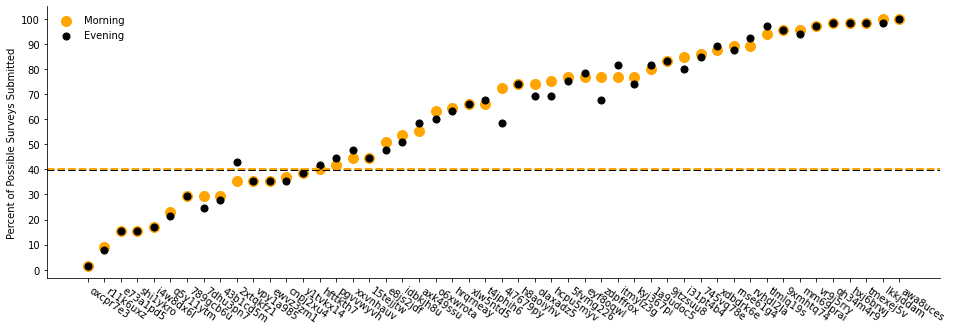

In [10]:
plot_total_submissions()

<div class="alert alert-block alert-info">
    <b>Possible Submissions</b><br> There are two participants who managed to turn in all possible morning surveys for the and one of those participants also turned in all evening surveys. The average line for the morning and evening submission averages are given and are nearly identical.
</div>

### Submissions Over Time
Here we look at the fallout and see how participation wanes during the study.

In [11]:
def plot_submission_timeline(morning=sleep_survey, evening=evening_survey, save=False):
    """
    
    """
    fig, ax = plt.subplots(figsize=(16,5))
    for df, color, size, label in zip([sleep_survey,evening_survey],["orange","black"],[100,50],["Morning","Evening"]):
        df["date"] = df.index.date
        WoY = []
        for d in df["date"]:
            WoY.append(d.isocalendar()[1])
        df["WoY"] = WoY
        counts_by_date = df.groupby("WoY").count()
        ax.scatter(counts_by_date.index,counts_by_date["beiwe"],color=color,s=size,label=label,zorder=2)

    ax.legend(frameon=False)
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)

    # x-axis
    ax.set_xticks(counts_by_date.index)
    ax.set_xticklabels(np.arange(1,len(counts_by_date)+1))
    ax.set_xlabel("Week of Study")

    # y-axis
    ax.set_ylabel("Number of Surveys Submitted")
    ax.set_yticks(np.arange(0,165,15))
    ax.set_ylim([0,150])
    if save:
        plt.savefig("../reports/figures/ema_summary/beiwe-submission_timeline_by_week-ux_s20.pdf")
    plt.show()
    plt.close()

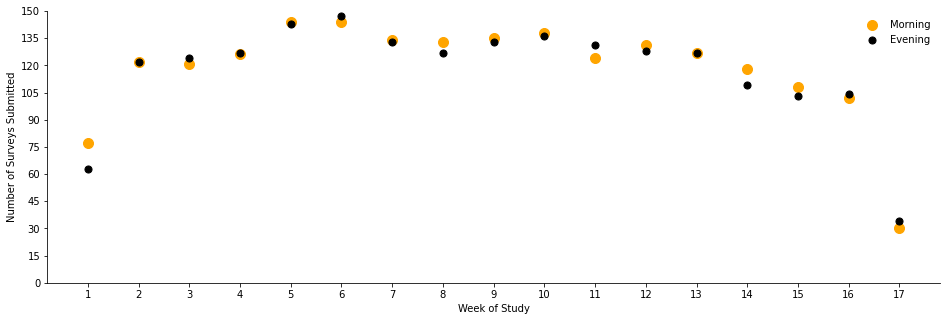

In [12]:
plot_submission_timeline()

<div class="alert alert-block alert-info">
    <b>Submission Timeline</b><br> As the study progresses, the number of surveys does seem to diminish slightly. 
</div>

### Submission Timestamps
Here we look at the actual timestamps that the surveys were submitted for both the morning and evening surveys.

In [64]:
def plot_submission_timestamp_strips(morning=sleep_survey, evening=evening_survey, save=False):
    """
    
    """
    morning["Survey"] = "Morning"
    evening["Survey"] = "Evening"
    daily_survey = morning.append(evening)
    daily_survey["hour"] = daily_survey.index.hour + daily_survey.index.minute/60
    fig, ax = plt.subplots(figsize=(6,6))
    sns.stripplot(x=daily_survey["Survey"],y=daily_survey["hour"], alpha=0.1,jitter=0.15,palette=["black","black"],ax=ax,zorder=3)
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)

    ax.set_ylim([-0.5,24.5])
    ax.set_yticks(np.arange(0,28,4))
    ax.set_ylabel("Hour of Day")

    ax.axhline(9,zorder=2,linestyle="dashed",color="cornflowerblue",alpha=0.5)
    ax.axhline(19,zorder=1,linestyle="dashed",color="cornflowerblue",alpha=0.5)
    
    if save:
        plt.savefig("../reports/figures/ema_summary/beiwe-submission_timestamp-stripplot-ux_s20.pdf")
    plt.show()
    plt.close()

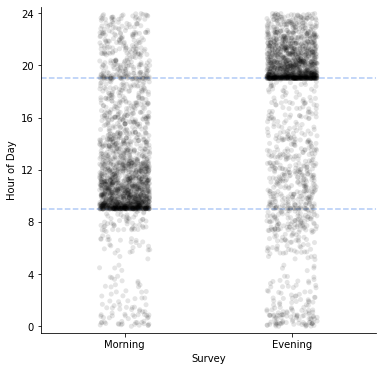

In [66]:
plot_submission_timestamp_strips()

<div class="alert alert-block alert-info">
    <b>Submission Timestamps Stripplot</b><br> Looks like the majority of students submitted the corresponding survey at the time it was sent out (9:00 for morning, 19:00 for evening). There is also a small, but noticeable increase in the morning survey submissions at 19:00 corresponding to the evening surveys.
</div>

In [84]:
def plot_submission_timestamp_histogram(morning=sleep_survey, evening=evening_survey, save=False):
    """
    
    """
    fig, axes = plt.subplots(1,2,figsize=(16,4),sharey="row")
    for df, ax, survey_type in zip([morning,evening], axes.flat, ["Morning", "Evening"]):
        df["hour"] = df.index.hour + df.index.minute/60
        n,bins,patches = ax.hist(df["hour"],bins=np.arange(0,25,1),rwidth=0.9,color="cornflowerblue",edgecolor="black",)
        ax.set_xticks(np.arange(0,25,2))

        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)

        ax.set_xlabel(survey_type)
        ax.set_ylabel("Count")
        
    plt.subplots_adjust(wspace=0.05)
    if save:
        plt.savefig("../reports/figures/ema_summary/beiwe-submission_timestamp-histogram-ux_s20.pdf")
    plt.show()
    plt.close()

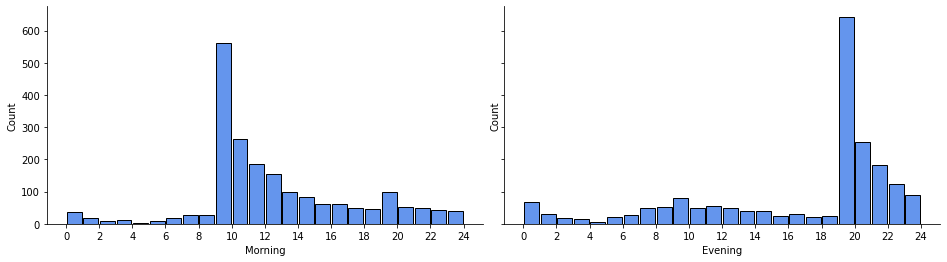

In [83]:
plot_submission_timestamp_histogram()

<div class="alert alert-block alert-info">
    <b>Submission Timestamps Histogram</b><br> Similar outcomes to the above figure
</div>

# Mood
We take a look at the mood data from the morning and evening surveys. The moods measured on these surveys are:
- content
- loneliness
- sadness
- stress
- energy level

## Summary
Starting with summarizing the data similar to the basics summarized above. 

### Aggregate Histogram

In [13]:
def label_hist(n, bins, ax):
    '''
    Labels the histogram with values above the bars
    
    Inputs:
    - n: the counts for each bin
    - bins: the actual bins limits
    
    Returns void
    '''
    k = []
    # calculate the relative frequency of each bin
    for i in range(0,len(n)):
        k.append(round((bins[i+1]-bins[i])*n[i],0))

    # plot the label/text to each bin
    for i in range(0, len(n)):
        x_pos = bins[i] + (bins[i+1] - bins[i]) / 2
        y_pos = n[i]
        label = str(k[i])[:-2] # relative frequency of each bin
        ax.text(x_pos, y_pos, label, ha='center', va='bottom')

In [90]:
def plot_mood_comparison_histogram(save=False):
    """
    Plots side-by-side histogram comparisions of the mood reportings for the morning and evening surveys. 
    """
    fig, axes = plt.subplots(5,2,figsize=(16,14),sharey='row')
    c = 0
    for df in [sleep_survey,evening_survey]:
        r = 0
        for question, color in zip(['content','stress','lonely','sad','energy'],['goldenrod','firebrick','violet','cornflowerblue','seagreen']):
            ax = axes[r,c]
            n,bins,patches = ax.hist(df[question],bins=[-0.5,0.5,1.5,2.5,3.5,4.5],rwidth=0.9,color=color,edgecolor="black")
            ax.set_xlabel(question)
            if c == 0:
                ax.set_ylabel('Frequency')
            ax.set_ylim([0,1500])

            ax.text(3.5,1000,f'n: {len(df[question])}')
            ax.text(3.5,800,f'Median: {np.nanmedian(df[question])}')

            label_hist(n, bins, ax)
            for loc in ["top","right"]:
                ax.spines[loc].set_visible(False)

            r += 1

        c += 1
        

    plt.subplots_adjust(wspace=0,hspace=0.35)
    if save:
        plt.savefig("../reports/figures/ema_summary/beiwe-all_moods-histogram-ux_s20.pdf")
    plt.show()
    plt.close()

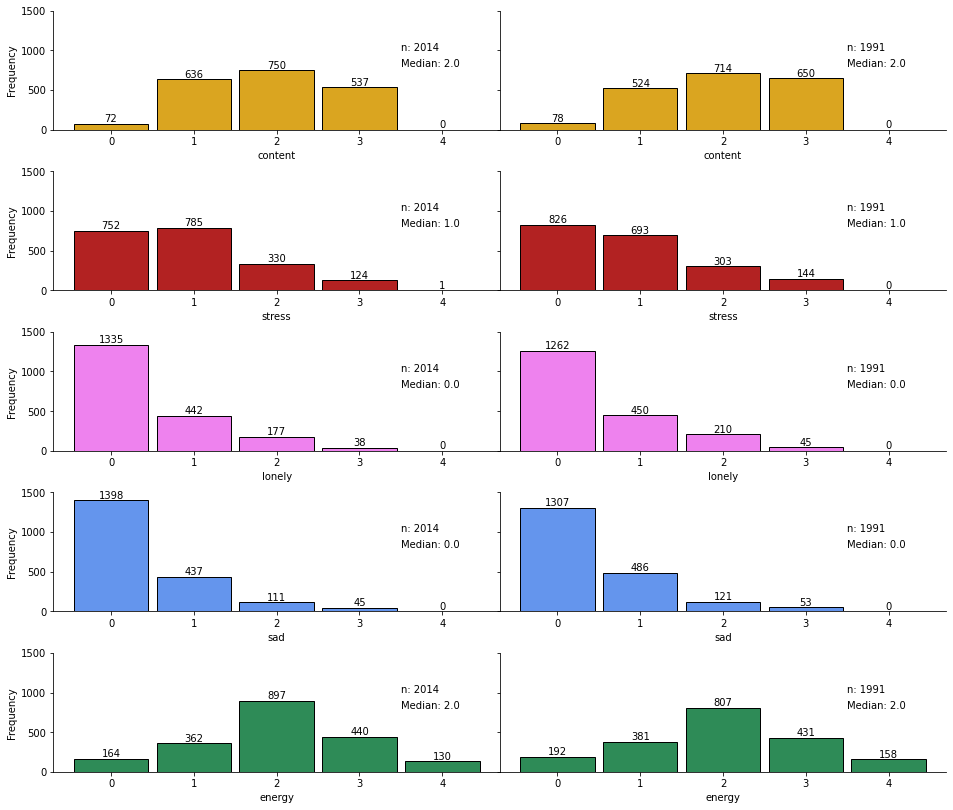

In [91]:
plot_mood_comparison_histogram()

# Sleep
Sleep portions of the survey includes:
- TST: total sleep time
- SOL: sleep onset latency
- NAW: number of awakenings
- Restful: Likert scale 0-3

## Summary
The following cells look at summarizing the results from the EMA surveys used to ask about sleep (distributed at 9:00 am every morning).

### Aggregate Histogram
Combining all participants across all question types

In [86]:
def plot_sleep_histogram(morning=sleep_survey,save=False):
    """
    
    """
    questions = ['tst','sol','naw','restful']
    xlabels = ["hours","minutes","count","score"]
    bin_list = [np.arange(0,15,1),
               np.arange(0,120,10),
               np.arange(-0.5,11.5,1),
               [-0.5,0.5,1.5,2.5,3.5,4.5]]

    fig, axes = plt.subplots(1,4,figsize=(24,4),sharey="row")
    for question, bins, ax, xlabel in zip(questions, bin_list, axes.flat, xlabels):
        n,bins,patches = ax.hist(morning[question],bins=bins,color="cornflowerblue",edgecolor="black", rwidth=0.9,align='mid')
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Frequency')
        ax.set_ylim([0,1000])

        ax.set_title(f'Median Response for {question}: {np.nanmedian(morning[question])}')

        label_hist(n, bins, ax)
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)

    plt.subplots_adjust(wspace=0.05)
    if save:
        plt.savefig("../reports/figures/ema_summary/beiwe-sleep_metrics-histogram-ux_s20.pdf")
    plt.show()
    plt.close()

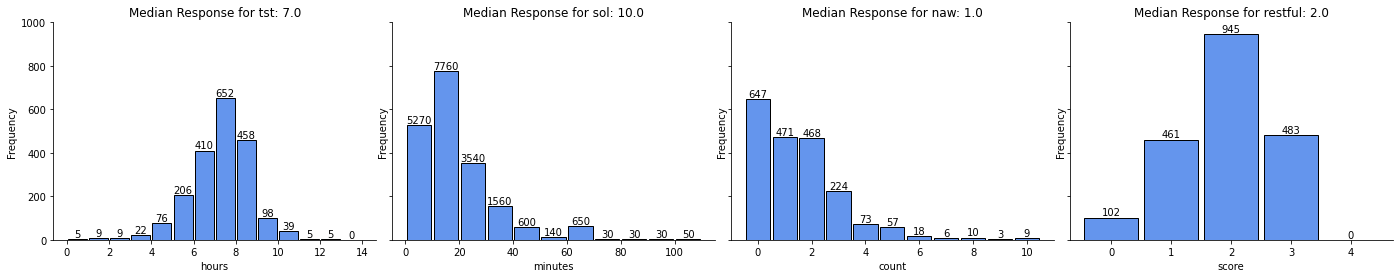

In [87]:
plot_sleep_histogram()

### Individual Histograms
A subplot of all participants with the bottom row corresponding to the aggregate.

<div class="alert alert-block alert-danger">
    A plot with 51x4 subplots seems a bit excessive to try
</div>

### Differences in the Day of the Week


Restricted to Beacon Participants Only: False


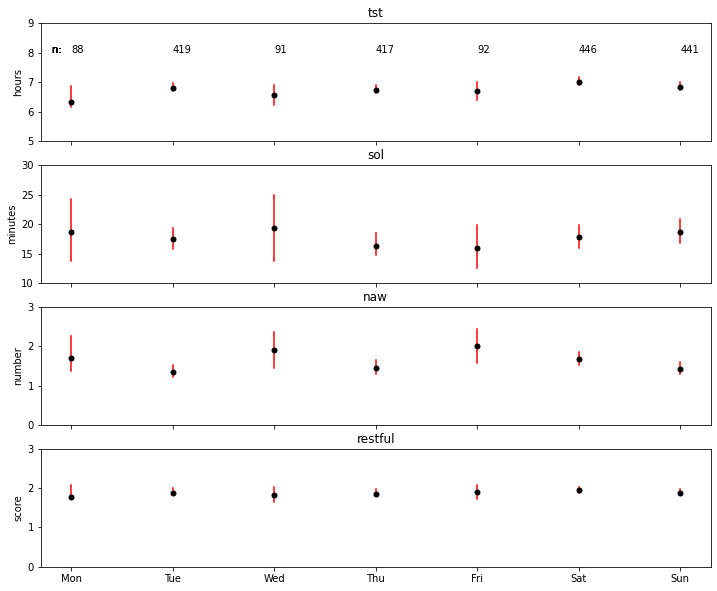

Restricted to Beacon Participants Only: True


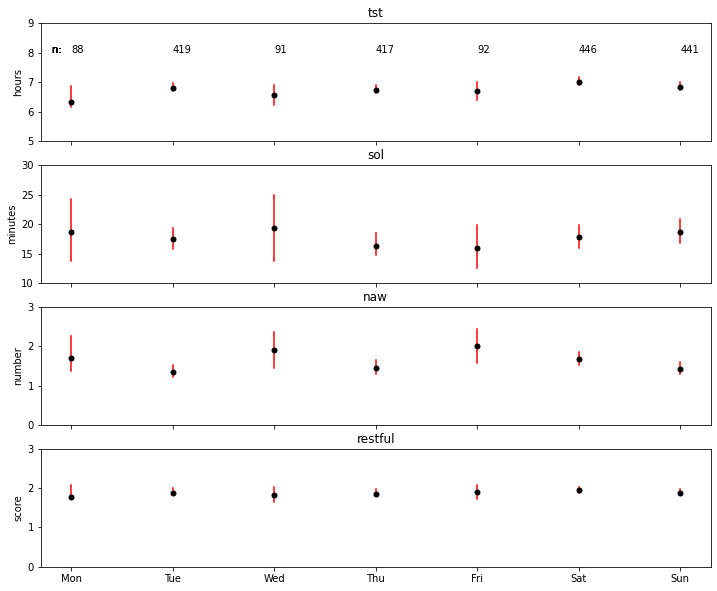

In [92]:
# grouping by night sleep (survey date - 1 day)
sleep_survey['DoW'] = (sleep_survey.index - timedelta(days=1)).strftime('%a')
# all participants
sleep_survey_dow = sleep_survey.groupby(['DoW']).mean()
sleep_survey_dow = sleep_survey_dow.reindex(["Mon", "Tue", "Wed","Thu","Fri","Sat",'Sun'])
# beacon-holding participants only
sleep_survey_restricted = sleep_survey[sleep_survey['beiwe'].isin(bid)]
sleep_survey_dow_beacon = sleep_survey_restricted.groupby(['DoW']).mean()
sleep_survey_dow_beacon = sleep_survey_dow_beacon.reindex(["Mon", "Tue", "Wed","Thu","Fri","Sat",'Sun'])
# looping through both dataframes
for df, restricted in zip([sleep_survey_dow,sleep_survey_dow_beacon],[False,True]):
    print(f'Restricted to Beacon Participants Only: {restricted}')
    fig, axes = plt.subplots(4,1,figsize=(12,10),sharex=True)
    i=0
    limits = [[5,9],[10,30],[0,3],[0,3]]
    for question, limit, ylabel in zip(['tst','sol','naw','restful'],limits,['hours','minutes','number','score']):

        sleep_survey_dow_plot = df[df[question] >= 0]
        # Scattering for day of week
        axes[i].scatter(sleep_survey_dow_plot.index,sleep_survey_dow_plot[question],s=25,color='black',zorder=10)
        axes[i].set_title(question)
        axes[i].set_ylim(limit)
        axes[i].set_ylabel(ylabel)

        # Adding 95% CI
        for day in sleep_survey['DoW'].unique():
            sleep_survey_by_day = sleep_survey[sleep_survey['DoW'] == day]
            if restricted:
                sleep_survey_by_day = sleep_survey_by_day[sleep_survey_by_day['beiwe'].isin(bid)]

            sleep_survey_by_day = sleep_survey_by_day[sleep_survey_by_day[question] >= 0]
            ci = st.t.interval(0.95, len(sleep_survey_by_day[question])-1,
                          loc=np.mean(sleep_survey_by_day[question]),
                          scale=st.sem(sleep_survey_by_day[question]))

            axes[i].plot([day,day],ci,color='red',zorder=1) 
            # adding number of surveys on top figure
            if question == 'tst':
                axes[i].text('Mon',8,'n:   ',ha='right')
                axes[i].text(day,8,len(sleep_survey_by_day))
        i += 1

    plt.subplots_adjust(wspace=0,hspace=0.2)
    plt.show()
    plt.close()

### Per Participant Responses

In [ ]:
# Sleep metrics
fig, axes = plt.subplots(4,1,figsize=(16,16),sharex=True)
sleep_survey_restricted = sleep_survey[sleep_survey['beiwe'].isin(bid)]
i = 0
for question, ylabel in zip(['tst','sol','naw','restful'],['hours','minutes','number','score']):
    sleep_survey_restricted_plot = sleep_survey_restricted[sleep_survey_restricted[question] >= 0]
    sns.stripplot(x='beiwe',y=question,data=sleep_survey_restricted_plot,color='black',alpha=0.1,ax=axes[i])
    axes[i].set_xlabel('')
    axes[i].set_ylabel(ylabel)
    axes[i].set_title(question)
    
    i += 1
    
plt.xticks(rotation=-30)
plt.subplots_adjust(hspace=0.2)
plt.show()
plt.close()

# Analysis on Fully Filtered Dataset
In the following cells, we only consider the data from the fully filtered dataset - that is data from nights when we have GPS confirming pts are home, Fitbit data confirming pts are asleep, and beacon data from their environment.

## Pre-Processing
We have the nights we need to consider, so first we have to filter the overall EMA dataframe by the nights present in the fully filtered beacon data.

In [ ]:
ff_df = pd.read_csv('../data/processed/beacon-fb_ema_and_gps_filtered-ux_s20.csv',
                                 index_col="timestamp", parse_dates=["timestamp","start_time","end_time"], infer_datetime_format=True)

Adding date columns to eventually merge on

In [ ]:
ff_df['date'] = ff_df['end_time'].dt.date
sleep_survey['date'] = sleep_survey.index.date

Merging the two dataframes to get the correct number of nights.

In [ ]:
ff_sleep_survey_df = pd.DataFrame() # dataframe to hold the relevant sleep EMAs
# looping through fully filtered data and merging dataframes on common start times
for pt in ff_df['beiwe'].unique():
    ff_sleep_pt = sleep_survey[sleep_survey['beiwe'] == pt]
    ff_pt = ff_df[ff_df['beiwe'] == pt]
    ff_pt_summary = ff_pt.groupby('date').mean()
    
    ff_sleep_survey_df = ff_sleep_survey_df.append(pd.merge(left=ff_sleep_pt,right=ff_pt_summary,left_on='date',right_on='date',how='inner'))

print('Number of nights with EMAs completed:', len(ff_sleep_survey_df))

In [ ]:
ff_sleep_survey_df.head()

<div class="alert alert-block alert-warning">
    Somehow we currently have one extra day (178 vs 177) than we should.
</div>

## Summary
The following cells highlight some summary information and illustrate it with figures.

In [ ]:
def plot_stacked_hist(df,var,limits,width=1,cmap='coolwarm',by_var='beiwe',save=False,save_dir='../reports/figures/'):
    '''
    Plots a stacked histogram with each color representing a unique individual.
    
    Inputs:
    - df: dataframe of the data
    - var: string specifying the column in the dataframe to plot
    - limits: tuple representing the lower and upper bound on the x-axis
    - width: integer/float for the width of each bin
    - by_var: string specifying the column to color the stacks by
    - save: boolean to save or not
    - save_dr: string representing the location to save the figure if save is True
    
    Returns the axes with the histogram
    '''
    list_to_plot = []
    for pt in df[by_var].unique():
        temp_df = df[df[by_var] == pt]
        list_to_plot.append(temp_df[var].to_list())
    
    colors = cm.get_cmap(cmap, len(list_to_plot))
    fig, ax = plt.subplots(figsize=(8,4))
    n, bins, _ = ax.hist(list_to_plot,bins=np.arange(limits[0],limits[1]+width,width),stacked=True,rwidth=0.9,
            color=colors(np.linspace(0, 1, len(list_to_plot))),edgecolor='black')
    
    for loc in ['right','top']:
        ax.spines[loc].set_visible(False)
    ax.set_ylabel('Count')

    if save == True:
        plt.savefig(f'{save_dir}/{var}-stacked_hist-ux_s20.pdf')
        
    return ax
    

### TST

In [ ]:
ax = plot_stacked_hist(ff_sleep_survey_df,'tst',[2,12],by_var='beiwe')
ax.set_ylim([0,100])
ax.set_xlabel('Hours')

ax.axvline(7,color='black',linestyle='dashed',linewidth=2)
ax.axvline(9,color='black',linestyle='dashed',linewidth=2)
ax.text(8,90,"Recommended",ha='center',va='center')

plt.savefig('../reports/figures/beiwe_sleep_duration-stacked_hist-ux_s20.pdf')
plt.show()
plt.close()

In [ ]:
p_7to9 = len(ff_sleep_survey_df[(ff_sleep_survey_df['tst'] >= 7) & (ff_sleep_survey_df['tst'] <= 9)])/len(ff_sleep_survey_df['tst'])
print('Number of nights between 7 and 9 hours of sleep:\t', p_7to9*100)

p_6to7 = len(ff_sleep_survey_df[(ff_sleep_survey_df['tst'] >= 6) & (ff_sleep_survey_df['tst'] < 7)])/len(ff_sleep_survey_df['tst'])
print('Number of nights between 6 and 7 hours of sleep:\t', p_6to7*100)

p_gt_7 = len(ff_sleep_survey_df[(ff_sleep_survey_df['tst'] >= 7)])/len(ff_sleep_survey_df['tst'])
print('Number of nights greater than 7 hours of sleep:\t\t', p_gt_7*100)

p_gt_9 = len(ff_sleep_survey_df[(ff_sleep_survey_df['tst'] > 9)])/len(ff_sleep_survey_df['tst'])
print('Number of nights greater than 9 hours of sleep:\t\t', p_gt_9*100)

p_lt_7 = len(ff_sleep_survey_df[(ff_sleep_survey_df['tst'] < 7)])/len(ff_sleep_survey_df['tst'])
print('Number of nights less than 7 hours of sleep:\t\t', p_lt_7*100)

Looking at the reported TSTs to see how participants tend to report TST.

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ff_sleep_survey_df.sort_values(['tst'],inplace=True)
ax. scatter(np.arange(0,len(ff_sleep_survey_df)), ff_sleep_survey_df['tst'])
ax.set_yticks(np.arange(2,12.5,0.25))
ax.grid(axis='y')

plt.show()
plt.close()

<div class="alert alert-block alert-success">
    Participants tend to report their TST at half-hour increments with two exceptions.
</div>

### SOL
We have SOL reported by the pts.

In [ ]:
ax = plot_stacked_hist(ff_sleep_survey_df,'sol',[0,60],width=5,by_var='beiwe')
ax.set_ylim([0,100])
ax.set_xlabel('Minutes')

ax.axvline(15,color='black',linestyle='dashed',linewidth=2)
ax.axvline(30,color='black',linestyle='dashed',linewidth=2)
ax.axvline(45,color='black',linestyle='dashed',linewidth=2)
ax.text(7.5,80,"Great",ha='center',va='center')
ax.text(22.5,80,"Good",ha='center',va='center')
ax.text(52.5,80,"Poor",ha='center',va='center')

plt.savefig('../reports/figures/beiwe_sleep_sol-stacked_hist-ux_s20.pdf')
plt.show()
plt.close()

In [ ]:
cutoffs = [15,30,50]
for cutoff in cutoffs:
    p_lt_cutoff = ff_sleep_survey_df[ff_sleep_survey_df['sol'] < cutoff]
    print(f'Percent of SOL less than {cutoff} minutes:', round(len(p_lt_cutoff)/len(ff_sleep_survey_df)*100,1))

In [ ]:
high_sol = ff_sleep_survey_df[ff_sleep_survey_df['sol'] >= 30]
high_sol

###  Awakenings

In [ ]:
ax = plot_stacked_hist(ff_sleep_survey_df,'naw',[0,11],width=1,by_var='beiwe')
ax.set_ylim([0,100])
ax.set_xlabel('Number')

# resetting xtick-labels
ax.set_xticks(np.arange(0.5,11.5,1))
ax.set_xticklabels(np.arange(0,11,1))

ax.axvline(2,color='black',linestyle='dashed',linewidth=2)
ax.axvline(4,color='black',linestyle='dashed',linewidth=2)
ax.text(1,80,"Good",ha='center',va='center')
ax.text(5,80,"Poor",ha='center',va='center')

plt.savefig('../reports/figures/beiwe_sleep_awakenings-stacked_hist-ux_s20.pdf')
plt.show()
plt.close()

In [ ]:
cutoffs = [2,4]
for cutoff in cutoffs:
    p_lt_cutoff = ff_sleep_survey_df[ff_sleep_survey_df['naw'] < cutoff]
    print(f'Percent of NAW less than {cutoff}:', round(len(p_lt_cutoff)/len(ff_sleep_survey_df)*100,1))

### Restful Score
On a scale of 0-3 (not at all to very much)

In [ ]:
ax = plot_stacked_hist(ff_sleep_survey_df,'restful',[0,4],width=1,by_var='beiwe')
ax.set_ylim([0,100])
ax.set_xticks([0.5,1.5,2.5,3.5])
ax.set_xticklabels(['0: Not at all','1: A little bit','2: Quite a bit','3: Very much'])
ax.set_xlabel('Response')

plt.savefig('../reports/figures/beiwe_sleep_restful-stacked_hist-ux_s20.pdf')
plt.show()
plt.close()

In [ ]:
for val in [0,1,2,3]:
    p = round(len(ff_sleep_survey_df[ff_sleep_survey_df['restful'] == val])/len(ff_sleep_survey_df)*100,1)
    print(f'Percent of Participants who rated their restfullness {val}: {p}')

Looking at the sleep summaries for those participants who had bad restfulness scores.

In [ ]:
rest_0 = ff_sleep_survey_df[ff_sleep_survey_df['restful'] == 0]
rest_0

### Comparing Poor Sleep Results
There are a few outlying individuals and it would be interesting to see how many of these individuals are present as outliers. 

#### Bad Everything
Here we check to see if any participant was poor in all four categories.

In [ ]:
bad_sleep = ff_sleep_survey_df[(ff_sleep_survey_df['tst'] < 6) & (ff_sleep_survey_df['sol'] >= 30) & (ff_sleep_survey_df['naw'] >= 4) & (ff_sleep_survey_df['restful'] == 0)]
bad_sleep

In [ ]:
tst_lt6 = ff_sleep_survey_df[ff_sleep_survey_df['tst'] < 6]
print(tst_lt6['beacon'].unique())

sol_gt30 = ff_sleep_survey_df[ff_sleep_survey_df['sol'] >= 30]
print(sol_gt30['beacon'].unique())

naw_gt4 = ff_sleep_survey_df[ff_sleep_survey_df['naw'] >= 4]
print(naw_gt4['beacon'].unique())

rest_0 = ff_sleep_survey_df[ff_sleep_survey_df['restful'] == 0]
print(rest_0['beacon'].unique())


<div class="alert alert-block alert-success">
    None of the participants scored poorly in all self-report sleep metrics.
</div>

#### Bad Restful and High NAW

In [ ]:
bad_sleep = ff_sleep_survey_df[(ff_sleep_survey_df['naw'] >= 4) & (ff_sleep_survey_df['restful'] == 0)]
bad_sleep

In [ ]:
ff_sleep_survey_df[ff_sleep_survey_df['naw'] == 10]

## Predictors for Poor Restful Scores
We want to see which other self-report sleep measures are the best predictors for a poor or good restful sleep score.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

### Binary Classification - All Restful Scores
Here we consider all restful scores, but classify them as either bad (0,1) or good (2,3). Thus we have a binary classification problem.

Getting the training data

In [ ]:
x = ff_sleep_survey_df[['tst','sol','naw']]
# rescaling SOL to hours
x['sol'] /= 60
y = ff_sleep_survey_df[['restful']]
y['score'] = np.where(y['restful'] < 2, 0, 1)
y.drop(['restful'],axis=1,inplace=True)

Fitting the model and getting the coefficients

In [ ]:
model = LogisticRegression(solver='lbfgs')
model.fit(x,y)
for sleep_metric, c in zip(x.columns.values,model.coef_[0]):
    print(f'{sleep_metric}: {round(c,3)}')
    
print(f'Intercept: {round(model.intercept_[0],3)}')

In [ ]:
# building the model and fitting the data 
x_sm = sm.add_constant(x)
log_reg = sm.Logit(y, x_sm).fit(method='lbfgs')
log_reg.summary()

<div class="alert alert-block alert-info">
    The TST seems to be the greatest predictor of restful sleep scores. 
<div>

We can look at the individual contributions to the restful score but plotting a one-var logit.

In [ ]:
fig, axes = plt.subplots(3,1,figsize=(12,12))
xs = np.arange(0,14.1,0.1)
ys = {'full':[],'tst':[],'sol':[],'naw':[]}
for x_val in xs:
    ys['full'].append(1 / (1+math.exp(-1*(model.intercept_[0]+x_val*model.coef_[0][0]+x_val*model.coef_[0][1]+x_val*model.coef_[0][2]))))
    ys['tst'].append(1 / (1+math.exp(-1*(model.intercept_[0]+x_val*model.coef_[0][0]))))
    ys['sol'].append(1 / (1+math.exp(-1*(model.intercept_[0]+x_val*model.coef_[0][1]))))
    ys['naw'].append(1 / (1+math.exp(-1*(model.intercept_[0]+x_val*model.coef_[0][2]))))
    
ax = axes[0]
ax.scatter(x['tst'],y['score'],color='cornflowerblue',edgecolor='black',s=50,label='Raw Data Points')
ax.plot(xs,ys['tst'],color='firebrick',linewidth=1,label='TST Only')
ax.set_xlabel('TST (hours)')

ax = axes[1]
ax.scatter(x['sol'],y['score'],color='cornflowerblue',edgecolor='black',s=50,label='Raw Data Points')
ax.plot(xs,ys['sol'],color='firebrick',linewidth=1,label='SOL Only')
ax.set_xlim([0,2])
ax.set_xlabel('SOL (hours)')

ax = axes[2]
ax.scatter(x['naw'],y['score'],color='cornflowerblue',edgecolor='black',s=50,label='Raw Data Points')
ax.plot(xs,ys['naw'],color='firebrick',linewidth=1,label='NAW Only')
ax.set_xlabel('Number of Awakenings')

for ax in axes:
    ax.set_ylim([-0.1,1.1])
    ax.set_yticks([0,1])

plt.subplots_adjust(hspace=0.2)
plt.show()
plt.close()


#### TST Only
Since TST seems to be the greatest predictor, we can create a model that takes into account only this parameter.

In [ ]:
# sklearn
model = LogisticRegression()
model.fit(x['tst'].values.reshape(-1, 1),y)

print(f'TST:', round(model.coef_[0][0],3))
print(f'Intercept: {round(model.intercept_[0],3)}')

In [ ]:
# statsmodels
x_sm = sm.add_constant(x['tst'])
log_reg = sm.Logit(y, x_sm).fit(method='lbfgs')
log_reg.summary()

Similar results to when we included the other sleep metrics.

### Binary Classification - Low and High Restful Scores
Now we look at only the extreme restfulness scores as those might be more reliable.

In [ ]:
df = ff_sleep_survey_df[(ff_sleep_survey_df['restful'] == 0.0)]
df = df.append(ff_sleep_survey_df[(ff_sleep_survey_df['restful'] == 3.0)])
x = df[['tst','sol','naw']]
# rescaling SOL to hours
x['sol'] /= 60
y = df[['restful']]
y['score'] = np.where(y['restful'] < 2, 0, 1)
y.drop(['restful'],axis=1,inplace=True)

Fitting the model

In [ ]:
# sklearn
model = LogisticRegression(solver='lbfgs')
model.fit(x,y)
for sleep_metric, c in zip(x.columns.values,model.coef_[0]):
    print(f'{sleep_metric}: {round(c,3)}')
    
print(f'Intercept: {round(model.intercept_[0],3)}')

In [ ]:
# statsmodels
x_sm = sm.add_constant(x)
log_reg = sm.Logit(y, x_sm).fit(method='lbfgs')
log_reg.summary()

In [ ]:
fig, axes = plt.subplots(3,1,figsize=(12,12))
xs = np.arange(0,14.1,0.1)
ys = {'full':[],'tst':[],'sol':[],'naw':[]}
for x_val in xs:
    ys['full'].append(1 / (1+math.exp(-1*(model.intercept_[0]+x_val*model.coef_[0][0]+x_val*model.coef_[0][1]+x_val*model.coef_[0][2]))))
    ys['tst'].append(1 / (1+math.exp(-1*(model.intercept_[0]+x_val*model.coef_[0][0]))))
    ys['sol'].append(1 / (1+math.exp(-1*(model.intercept_[0]+x_val*model.coef_[0][1]))))
    ys['naw'].append(1 / (1+math.exp(-1*(model.intercept_[0]+x_val*model.coef_[0][2]))))
    
ax = axes[0]
ax.scatter(x['tst'],y['score'],color='cornflowerblue',edgecolor='black',s=50,label='Raw Data Points')
ax.plot(xs,ys['tst'],color='firebrick',linewidth=1,label='TST Only')
ax.set_xlabel('TST (hours)')

ax = axes[1]
ax.scatter(x['sol'],y['score'],color='cornflowerblue',edgecolor='black',s=50,label='Raw Data Points')
ax.plot(xs,ys['sol'],color='firebrick',linewidth=1,label='SOL Only')
ax.set_xlim([0,2])
ax.set_xlabel('SOL (hours)')

ax = axes[2]
ax.scatter(x['naw'],y['score'],color='cornflowerblue',edgecolor='black',s=50,label='Raw Data Points')
ax.plot(xs,ys['naw'],color='firebrick',linewidth=1,label='NAW Only')
ax.set_xlabel('Number of Awakenings')

for ax in axes:
    ax.set_ylim([-0.1,1.1])
    ax.set_yticks([0,1])

plt.subplots_adjust(hspace=0.2)
plt.show()
plt.close()


<div class="alert alert-block alert-info">
    The TST seems to be the greatest predictor of restful even under this regime, but the relationship is weaker in this instance. This is unfortunate considering this scheme should produce more dramatic differences. 
<div>